In [1]:
import numpy as np
import pandas as pd
import joblib

# Torch
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, recall_score

In [2]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

**A. Loading our inputs for training**

In [3]:
df_inputs = torch.load('tensors/df_inputs.pt')
df_inputs

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0007, 0.0021, 0.0014,  ..., 0.0008, 0.0012, 0.0011],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

**B. Loading our targets for training**

In [4]:
df_targets = torch.load('tensors/df_targets.pt')
df_targets

tensor([1, 2, 1,  ..., 0, 1, 1])

**C. Loading our inputs for testing**

In [5]:
X_test_vec = torch.load('tensors/X_test_vec.pt')
X_test_vec

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

**D. Loading our targets for testing**

In [6]:
y_test = torch.load('tensors/y_test.pt')
y_test

tensor([1, 2, 2,  ..., 1, 2, 1])

In [7]:
NUM_CLASSES = 3
NUM_FEATURES = 5000

class BalancedNeuralNetwork(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.hidden_layer_1 = nn.Linear(self.in_dim, 50) # input to first hidden layer, produces 50 features
        self.output_layer = nn.Linear(50, self.out_dim) # takes in 50 features, produces 3 feature (y)
        #self.dropout = nn.Dropout(p=0.7)
        self.activation = nn.ReLU()  # <- add in ReLU activation function

    def forward(self, x):
        #x = self.dropout(self.activation(self.hidden_layer_1(x)))
        x = self.activation(self.hidden_layer_1(x))
        y = self.output_layer(x)
        
        return y

In [8]:
# Create an instance of the model and send it to target device
model_2 = BalancedNeuralNetwork(in_dim=NUM_FEATURES, out_dim=NUM_CLASSES).to(device)
model_2

BalancedNeuralNetwork(
  (hidden_layer_1): Linear(in_features=5000, out_features=50, bias=True)
  (output_layer): Linear(in_features=50, out_features=3, bias=True)
  (activation): ReLU()
)

In [9]:
learning_rate_2 = 0.0001
loss_fn_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.Adam(model_2.parameters(), lr=learning_rate_2)
batch_size = 128

In [10]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class MyCustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [11]:
# Define the training process
# Each call of the train function == 1 Epoch
import time
def train_fn(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (features, targets) in enumerate(loop):
        y_logits = model.forward(features)

        # Calculate loss
        loss = loss_fn(y_logits, targets)
        
        # Optimizer zero grad
        optimizer.zero_grad()
        
        # Loss backwards
        loss.backward()
        
        # Optimizer Step
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

# Dataloader is in charge of:
# - partitioning data into batches
# - optionally shuffling the data
# - run the optimizer against a partition defined by this loader
custom_dataset_2 = MyCustomDataset(x=df_inputs, y=df_targets)

train_loader = DataLoader(
    custom_dataset_2,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

epochs = 200
losses_2 = []

start = time.time()
for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn(
        train_loader,
        model_2,
        optimizer_2,
        loss_fn_2,
        batch_size
    )
    
    losses_2.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))

end = time.time()    
print(f'Training duration: {(end-start)} seconds')

state = { 'state_dict': model_2.state_dict() }
torch.save(state, "./torch_models/model_2.pth")

Epoch: 0


100%|██████████| 492/492 [00:07<00:00, 65.52it/s, loss=1.04]


Ave Loss: 1.0777813632313797
Epoch: 1


100%|██████████| 492/492 [00:08<00:00, 57.13it/s, loss=0.918]


Ave Loss: 0.9962055428725917
Epoch: 2


100%|██████████| 492/492 [00:07<00:00, 68.42it/s, loss=0.808]


Ave Loss: 0.8965426488378183
Epoch: 3


100%|██████████| 492/492 [00:08<00:00, 60.22it/s, loss=0.727]


Ave Loss: 0.8173133260835477
Epoch: 4


100%|██████████| 492/492 [00:08<00:00, 55.25it/s, loss=0.668]


Ave Loss: 0.7599136708228569
Epoch: 5


100%|██████████| 492/492 [00:06<00:00, 73.84it/s, loss=0.623]


Ave Loss: 0.718762281585515
Epoch: 6


100%|██████████| 492/492 [00:07<00:00, 67.39it/s, loss=0.589]


Ave Loss: 0.6882077517305932
Epoch: 7


100%|██████████| 492/492 [00:07<00:00, 63.49it/s, loss=0.562]


Ave Loss: 0.6646481434988781
Epoch: 8


100%|██████████| 492/492 [00:07<00:00, 66.23it/s, loss=0.54] 


Ave Loss: 0.6459222469872575
Epoch: 9


100%|██████████| 492/492 [00:07<00:00, 62.59it/s, loss=0.522]


Ave Loss: 0.6308403040577726
Epoch: 10


100%|██████████| 492/492 [00:07<00:00, 62.36it/s, loss=0.507]


Ave Loss: 0.6183992627917266
Epoch: 11


100%|██████████| 492/492 [00:07<00:00, 68.56it/s, loss=0.495]


Ave Loss: 0.6079273813866019
Epoch: 12


100%|██████████| 492/492 [00:06<00:00, 76.16it/s, loss=0.485]


Ave Loss: 0.5989531562701473
Epoch: 13


100%|██████████| 492/492 [00:06<00:00, 74.09it/s, loss=0.476]


Ave Loss: 0.591141053573872
Epoch: 14


100%|██████████| 492/492 [00:06<00:00, 74.02it/s, loss=0.469]


Ave Loss: 0.5842502280706312
Epoch: 15


100%|██████████| 492/492 [00:06<00:00, 75.62it/s, loss=0.463]


Ave Loss: 0.5780976861715317
Epoch: 16


100%|██████████| 492/492 [00:06<00:00, 71.51it/s, loss=0.457]


Ave Loss: 0.5725457154638399
Epoch: 17


100%|██████████| 492/492 [00:07<00:00, 63.86it/s, loss=0.452]


Ave Loss: 0.5674906244001737
Epoch: 18


100%|██████████| 492/492 [00:07<00:00, 67.17it/s, loss=0.448]


Ave Loss: 0.5628469846234089
Epoch: 19


100%|██████████| 492/492 [00:07<00:00, 68.57it/s, loss=0.445]


Ave Loss: 0.5585513545003363
Epoch: 20


100%|██████████| 492/492 [00:07<00:00, 63.29it/s, loss=0.441]


Ave Loss: 0.554554118979268
Epoch: 21


100%|██████████| 492/492 [00:07<00:00, 69.82it/s, loss=0.438]


Ave Loss: 0.5508136393093481
Epoch: 22


100%|██████████| 492/492 [00:06<00:00, 73.90it/s, loss=0.435]


Ave Loss: 0.547297298787086
Epoch: 23


100%|██████████| 492/492 [00:06<00:00, 74.98it/s, loss=0.432]


Ave Loss: 0.543978494841878
Epoch: 24


100%|██████████| 492/492 [00:06<00:00, 70.59it/s, loss=0.43] 


Ave Loss: 0.5408350773216263
Epoch: 25


100%|██████████| 492/492 [00:07<00:00, 63.88it/s, loss=0.427]


Ave Loss: 0.5378479244626635
Epoch: 26


100%|██████████| 492/492 [00:07<00:00, 64.74it/s, loss=0.425]


Ave Loss: 0.5350003555053617
Epoch: 27


100%|██████████| 492/492 [00:07<00:00, 69.84it/s, loss=0.423]


Ave Loss: 0.5322801435623712
Epoch: 28


100%|██████████| 492/492 [00:06<00:00, 76.99it/s, loss=0.42] 


Ave Loss: 0.5296763449422712
Epoch: 29


100%|██████████| 492/492 [00:06<00:00, 77.53it/s, loss=0.418]


Ave Loss: 0.5271802201745955
Epoch: 30


100%|██████████| 492/492 [00:06<00:00, 76.94it/s, loss=0.416]


Ave Loss: 0.5247834306664583
Epoch: 31


100%|██████████| 492/492 [00:06<00:00, 76.18it/s, loss=0.414]


Ave Loss: 0.5224766127341162
Epoch: 32


100%|██████████| 492/492 [00:06<00:00, 74.15it/s, loss=0.412]


Ave Loss: 0.5202540029597477
Epoch: 33


100%|██████████| 492/492 [00:06<00:00, 76.10it/s, loss=0.41] 


Ave Loss: 0.5181098563399741
Epoch: 34


100%|██████████| 492/492 [00:06<00:00, 74.51it/s, loss=0.408]


Ave Loss: 0.5160381431744351
Epoch: 35


100%|██████████| 492/492 [00:06<00:00, 74.45it/s, loss=0.406]


Ave Loss: 0.5140340169513129
Epoch: 36


100%|██████████| 492/492 [00:06<00:00, 75.26it/s, loss=0.404]


Ave Loss: 0.5120915278671233
Epoch: 37


100%|██████████| 492/492 [00:06<00:00, 75.14it/s, loss=0.402]


Ave Loss: 0.5102089862149906
Epoch: 38


100%|██████████| 492/492 [00:06<00:00, 74.76it/s, loss=0.4]  


Ave Loss: 0.50838106470864
Epoch: 39


100%|██████████| 492/492 [00:06<00:00, 73.88it/s, loss=0.398]


Ave Loss: 0.5066011939954952
Epoch: 40


100%|██████████| 492/492 [00:06<00:00, 74.95it/s, loss=0.397]


Ave Loss: 0.5048739589690193
Epoch: 41


100%|██████████| 492/492 [00:06<00:00, 76.46it/s, loss=0.395]


Ave Loss: 0.5031932821966768
Epoch: 42


100%|██████████| 492/492 [00:06<00:00, 74.28it/s, loss=0.393]


Ave Loss: 0.5015561557034167
Epoch: 43


100%|██████████| 492/492 [00:06<00:00, 74.86it/s, loss=0.391]


Ave Loss: 0.4999617016533526
Epoch: 44


100%|██████████| 492/492 [00:06<00:00, 74.90it/s, loss=0.389]


Ave Loss: 0.4984077634971316
Epoch: 45


100%|██████████| 492/492 [00:06<00:00, 74.96it/s, loss=0.388]


Ave Loss: 0.4968890213384861
Epoch: 46


100%|██████████| 492/492 [00:06<00:00, 76.09it/s, loss=0.386]


Ave Loss: 0.49540508817124174
Epoch: 47


100%|██████████| 492/492 [00:06<00:00, 75.84it/s, loss=0.384]


Ave Loss: 0.4939505585688886
Epoch: 48


100%|██████████| 492/492 [00:06<00:00, 74.45it/s, loss=0.383]


Ave Loss: 0.4925301789752836
Epoch: 49


100%|██████████| 492/492 [00:06<00:00, 75.02it/s, loss=0.381]


Ave Loss: 0.491137105880714
Epoch: 50


100%|██████████| 492/492 [00:06<00:00, 75.04it/s, loss=0.379]


Ave Loss: 0.4897758715399882
Epoch: 51


100%|██████████| 492/492 [00:06<00:00, 75.45it/s, loss=0.378]


Ave Loss: 0.48843885691669897
Epoch: 52


100%|██████████| 492/492 [00:06<00:00, 74.08it/s, loss=0.376]


Ave Loss: 0.48712885179897636
Epoch: 53


100%|██████████| 492/492 [00:07<00:00, 68.83it/s, loss=0.374]


Ave Loss: 0.48584255872945475
Epoch: 54


100%|██████████| 492/492 [00:07<00:00, 61.94it/s, loss=0.373]


Ave Loss: 0.48458004276442335
Epoch: 55


100%|██████████| 492/492 [00:08<00:00, 55.88it/s, loss=0.371]


Ave Loss: 0.4833383327577172
Epoch: 56


100%|██████████| 492/492 [00:07<00:00, 65.31it/s, loss=0.37] 


Ave Loss: 0.48211668001684715
Epoch: 57


100%|██████████| 492/492 [00:06<00:00, 72.81it/s, loss=0.368]


Ave Loss: 0.4809128573633791
Epoch: 58


100%|██████████| 492/492 [00:06<00:00, 73.36it/s, loss=0.367]


Ave Loss: 0.4797281747063001
Epoch: 59


100%|██████████| 492/492 [00:07<00:00, 62.99it/s, loss=0.365]


Ave Loss: 0.4785606488585472
Epoch: 60


100%|██████████| 492/492 [00:06<00:00, 72.42it/s, loss=0.364]


Ave Loss: 0.4774074664081984
Epoch: 61


100%|██████████| 492/492 [00:06<00:00, 73.83it/s, loss=0.362]


Ave Loss: 0.4762677945862941
Epoch: 62


100%|██████████| 492/492 [00:07<00:00, 63.41it/s, loss=0.361]


Ave Loss: 0.47514153041732987
Epoch: 63


100%|██████████| 492/492 [00:07<00:00, 62.46it/s, loss=0.359]


Ave Loss: 0.4740304932967434
Epoch: 64


100%|██████████| 492/492 [00:06<00:00, 73.08it/s, loss=0.358]


Ave Loss: 0.47293064640304905
Epoch: 65


100%|██████████| 492/492 [00:08<00:00, 60.84it/s, loss=0.356]


Ave Loss: 0.47184256464242935
Epoch: 66


100%|██████████| 492/492 [00:07<00:00, 67.40it/s, loss=0.355]


Ave Loss: 0.4707688603822778
Epoch: 67


100%|██████████| 492/492 [00:07<00:00, 63.36it/s, loss=0.353]


Ave Loss: 0.46970614578908054
Epoch: 68


100%|██████████| 492/492 [00:07<00:00, 63.35it/s, loss=0.352]


Ave Loss: 0.4686556007198202
Epoch: 69


100%|██████████| 492/492 [00:06<00:00, 74.95it/s, loss=0.351]


Ave Loss: 0.46761091719797954
Epoch: 70


100%|██████████| 492/492 [00:06<00:00, 74.86it/s, loss=0.349]


Ave Loss: 0.4665772885811038
Epoch: 71


100%|██████████| 492/492 [00:06<00:00, 73.47it/s, loss=0.348]


Ave Loss: 0.4655511215086875
Epoch: 72


100%|██████████| 492/492 [00:06<00:00, 73.23it/s, loss=0.346]


Ave Loss: 0.4645326456161049
Epoch: 73


100%|██████████| 492/492 [00:06<00:00, 75.45it/s, loss=0.345]


Ave Loss: 0.4635215117558231
Epoch: 74


100%|██████████| 492/492 [00:06<00:00, 71.02it/s, loss=0.344]


Ave Loss: 0.46251354687582186
Epoch: 75


100%|██████████| 492/492 [00:07<00:00, 61.93it/s, loss=0.342]


Ave Loss: 0.4615131992150128
Epoch: 76


100%|██████████| 492/492 [00:07<00:00, 66.56it/s, loss=0.341]


Ave Loss: 0.4605214244466487
Epoch: 77


100%|██████████| 492/492 [00:07<00:00, 67.57it/s, loss=0.34] 


Ave Loss: 0.4595308721792407
Epoch: 78


100%|██████████| 492/492 [00:07<00:00, 68.32it/s, loss=0.338]


Ave Loss: 0.458549445116423
Epoch: 79


100%|██████████| 492/492 [00:07<00:00, 69.77it/s, loss=0.337]


Ave Loss: 0.45757336187653425
Epoch: 80


100%|██████████| 492/492 [00:07<00:00, 66.41it/s, loss=0.335]


Ave Loss: 0.4565966503043485
Epoch: 81


100%|██████████| 492/492 [00:07<00:00, 62.02it/s, loss=0.334]


Ave Loss: 0.4556256216473696
Epoch: 82


100%|██████████| 492/492 [00:07<00:00, 63.95it/s, loss=0.333]


Ave Loss: 0.45465347388895544
Epoch: 83


100%|██████████| 492/492 [00:08<00:00, 59.40it/s, loss=0.331]


Ave Loss: 0.45368785816964097
Epoch: 84


100%|██████████| 492/492 [00:06<00:00, 70.82it/s, loss=0.33] 


Ave Loss: 0.4527237109415899
Epoch: 85


100%|██████████| 492/492 [00:06<00:00, 73.36it/s, loss=0.329]


Ave Loss: 0.4517601228099528
Epoch: 86


100%|██████████| 492/492 [00:06<00:00, 73.85it/s, loss=0.327]


Ave Loss: 0.4508012935398071
Epoch: 87


100%|██████████| 492/492 [00:07<00:00, 63.97it/s, loss=0.326]


Ave Loss: 0.4498384734237097
Epoch: 88


100%|██████████| 492/492 [00:07<00:00, 66.13it/s, loss=0.324]


Ave Loss: 0.4488862105380229
Epoch: 89


100%|██████████| 492/492 [00:07<00:00, 63.10it/s, loss=0.323]


Ave Loss: 0.447928014870097
Epoch: 90


100%|██████████| 492/492 [00:07<00:00, 66.52it/s, loss=0.322]


Ave Loss: 0.4469687229976421
Epoch: 91


100%|██████████| 492/492 [00:07<00:00, 67.05it/s, loss=0.321]


Ave Loss: 0.4460148380660429
Epoch: 92


100%|██████████| 492/492 [00:07<00:00, 64.32it/s, loss=0.319]


Ave Loss: 0.44505767366750454
Epoch: 93


100%|██████████| 492/492 [00:06<00:00, 71.11it/s, loss=0.318]


Ave Loss: 0.44410017078242653
Epoch: 94


100%|██████████| 492/492 [00:06<00:00, 71.84it/s, loss=0.317]


Ave Loss: 0.44314705719792746
Epoch: 95


100%|██████████| 492/492 [00:06<00:00, 72.11it/s, loss=0.315]


Ave Loss: 0.44219077620806735
Epoch: 96


100%|██████████| 492/492 [00:06<00:00, 73.32it/s, loss=0.314]


Ave Loss: 0.4412299165638482
Epoch: 97


100%|██████████| 492/492 [00:07<00:00, 63.03it/s, loss=0.313]


Ave Loss: 0.4402708015669652
Epoch: 98


100%|██████████| 492/492 [00:07<00:00, 65.51it/s, loss=0.311]


Ave Loss: 0.4393078030609503
Epoch: 99


100%|██████████| 492/492 [00:07<00:00, 64.07it/s, loss=0.31] 


Ave Loss: 0.43834633701215914
Epoch: 100


100%|██████████| 492/492 [00:07<00:00, 69.77it/s, loss=0.309]


Ave Loss: 0.43737798293189306
Epoch: 101


100%|██████████| 492/492 [00:06<00:00, 71.34it/s, loss=0.308]


Ave Loss: 0.43641291813152594
Epoch: 102


100%|██████████| 492/492 [00:06<00:00, 74.51it/s, loss=0.306]


Ave Loss: 0.4354429074176928
Epoch: 103


100%|██████████| 492/492 [00:06<00:00, 71.68it/s, loss=0.305]


Ave Loss: 0.4344707711683056
Epoch: 104


100%|██████████| 492/492 [00:06<00:00, 72.07it/s, loss=0.304]


Ave Loss: 0.4335010526626091
Epoch: 105


100%|██████████| 492/492 [00:07<00:00, 66.09it/s, loss=0.303]


Ave Loss: 0.4325257759026396
Epoch: 106


100%|██████████| 492/492 [00:07<00:00, 62.21it/s, loss=0.302]


Ave Loss: 0.43154956030894104
Epoch: 107


100%|██████████| 492/492 [00:06<00:00, 71.61it/s, loss=0.3]  


Ave Loss: 0.4305702422450228
Epoch: 108


100%|██████████| 492/492 [00:07<00:00, 68.94it/s, loss=0.299]


Ave Loss: 0.4295886957306203
Epoch: 109


100%|██████████| 492/492 [00:06<00:00, 73.01it/s, loss=0.298]


Ave Loss: 0.42860579199907256
Epoch: 110


100%|██████████| 492/492 [00:06<00:00, 72.97it/s, loss=0.297]


Ave Loss: 0.42761942574648354
Epoch: 111


100%|██████████| 492/492 [00:06<00:00, 72.11it/s, loss=0.296]


Ave Loss: 0.4266229139232054
Epoch: 112


100%|██████████| 492/492 [00:08<00:00, 56.77it/s, loss=0.294]


Ave Loss: 0.4256298577155524
Epoch: 113


100%|██████████| 492/492 [00:07<00:00, 68.39it/s, loss=0.293]


Ave Loss: 0.4246322670118596
Epoch: 114


100%|██████████| 492/492 [00:07<00:00, 69.69it/s, loss=0.292]


Ave Loss: 0.4236288343260928
Epoch: 115


100%|██████████| 492/492 [00:06<00:00, 70.48it/s, loss=0.291]


Ave Loss: 0.42262488918575813
Epoch: 116


100%|██████████| 492/492 [00:07<00:00, 65.78it/s, loss=0.289]


Ave Loss: 0.421612495995634
Epoch: 117


100%|██████████| 492/492 [00:07<00:00, 66.39it/s, loss=0.288]


Ave Loss: 0.42060356659860143
Epoch: 118


100%|██████████| 492/492 [00:07<00:00, 67.26it/s, loss=0.287]


Ave Loss: 0.4195881796077015
Epoch: 119


100%|██████████| 492/492 [00:07<00:00, 65.60it/s, loss=0.286]


Ave Loss: 0.41856375524425893
Epoch: 120


100%|██████████| 492/492 [00:07<00:00, 69.05it/s, loss=0.284]


Ave Loss: 0.4175410806769278
Epoch: 121


100%|██████████| 492/492 [00:07<00:00, 65.88it/s, loss=0.283]


Ave Loss: 0.41651364845958183
Epoch: 122


100%|██████████| 492/492 [00:06<00:00, 70.63it/s, loss=0.282]


Ave Loss: 0.41548244964058806
Epoch: 123


100%|██████████| 492/492 [00:07<00:00, 69.71it/s, loss=0.281]


Ave Loss: 0.4144436019828649
Epoch: 124


100%|██████████| 492/492 [00:07<00:00, 68.70it/s, loss=0.28] 


Ave Loss: 0.41340325851508275
Epoch: 125


100%|██████████| 492/492 [00:07<00:00, 67.00it/s, loss=0.278]


Ave Loss: 0.41235944980043704
Epoch: 126


100%|██████████| 492/492 [00:07<00:00, 69.23it/s, loss=0.277]


Ave Loss: 0.4113051878606401
Epoch: 127


100%|██████████| 492/492 [00:07<00:00, 70.08it/s, loss=0.276]


Ave Loss: 0.41025103840643795
Epoch: 128


100%|██████████| 492/492 [00:06<00:00, 75.78it/s, loss=0.275]


Ave Loss: 0.40919072817011576
Epoch: 129


100%|██████████| 492/492 [00:06<00:00, 74.22it/s, loss=0.273]


Ave Loss: 0.40812928471865695
Epoch: 130


100%|██████████| 492/492 [00:06<00:00, 76.05it/s, loss=0.272]


Ave Loss: 0.40705581209281594
Epoch: 131


100%|██████████| 492/492 [00:06<00:00, 74.79it/s, loss=0.271]


Ave Loss: 0.4059838126224231
Epoch: 132


100%|██████████| 492/492 [00:06<00:00, 75.79it/s, loss=0.27] 


Ave Loss: 0.40490322784195104
Epoch: 133


100%|██████████| 492/492 [00:06<00:00, 75.72it/s, loss=0.268]


Ave Loss: 0.40381950267204425
Epoch: 134


100%|██████████| 492/492 [00:06<00:00, 74.64it/s, loss=0.267]


Ave Loss: 0.4027273246064419
Epoch: 135


100%|██████████| 492/492 [00:07<00:00, 67.80it/s, loss=0.266]


Ave Loss: 0.4016352943409749
Epoch: 136


100%|██████████| 492/492 [00:07<00:00, 61.90it/s, loss=0.265]


Ave Loss: 0.40053539759502177
Epoch: 137


100%|██████████| 492/492 [00:07<00:00, 61.65it/s, loss=0.263]


Ave Loss: 0.39942989377229193
Epoch: 138


100%|██████████| 492/492 [00:07<00:00, 63.60it/s, loss=0.262]


Ave Loss: 0.39832111841779416
Epoch: 139


100%|██████████| 492/492 [00:07<00:00, 67.28it/s, loss=0.261]


Ave Loss: 0.39720767821238295
Epoch: 140


100%|██████████| 492/492 [00:06<00:00, 75.30it/s, loss=0.26] 


Ave Loss: 0.3960907958387359
Epoch: 141


100%|██████████| 492/492 [00:06<00:00, 74.74it/s, loss=0.258]


Ave Loss: 0.39496742855242595
Epoch: 142


100%|██████████| 492/492 [00:06<00:00, 71.07it/s, loss=0.257]


Ave Loss: 0.3938416341940562
Epoch: 143


100%|██████████| 492/492 [00:07<00:00, 68.93it/s, loss=0.256]


Ave Loss: 0.3927107858585148
Epoch: 144


100%|██████████| 492/492 [00:07<00:00, 69.56it/s, loss=0.255]


Ave Loss: 0.3915754335561419
Epoch: 145


100%|██████████| 492/492 [00:07<00:00, 68.81it/s, loss=0.253]


Ave Loss: 0.3904285574468171
Epoch: 146


100%|██████████| 492/492 [00:07<00:00, 63.64it/s, loss=0.252]


Ave Loss: 0.3892818793533294
Epoch: 147


100%|██████████| 492/492 [00:07<00:00, 63.16it/s, loss=0.251]


Ave Loss: 0.3881322583410798
Epoch: 148


100%|██████████| 492/492 [00:06<00:00, 71.08it/s, loss=0.25] 


Ave Loss: 0.3869764943554149
Epoch: 149


100%|██████████| 492/492 [00:07<00:00, 68.52it/s, loss=0.249]


Ave Loss: 0.3858169534705519
Epoch: 150


100%|██████████| 492/492 [00:06<00:00, 70.87it/s, loss=0.248]


Ave Loss: 0.3846489844041142
Epoch: 151


100%|██████████| 492/492 [00:07<00:00, 69.48it/s, loss=0.246]


Ave Loss: 0.3834754669872241
Epoch: 152


100%|██████████| 492/492 [00:07<00:00, 67.74it/s, loss=0.245]


Ave Loss: 0.3823008232909005
Epoch: 153


100%|██████████| 492/492 [00:07<00:00, 70.09it/s, loss=0.244]


Ave Loss: 0.3811208881680074
Epoch: 154


100%|██████████| 492/492 [00:07<00:00, 69.16it/s, loss=0.243]


Ave Loss: 0.37993223725901387
Epoch: 155


100%|██████████| 492/492 [00:07<00:00, 66.63it/s, loss=0.242]


Ave Loss: 0.3787416883600437
Epoch: 156


100%|██████████| 492/492 [00:07<00:00, 65.14it/s, loss=0.241]


Ave Loss: 0.37754108499341865
Epoch: 157


100%|██████████| 492/492 [00:07<00:00, 65.92it/s, loss=0.239]


Ave Loss: 0.37634365926913127
Epoch: 158


100%|██████████| 492/492 [00:07<00:00, 66.00it/s, loss=0.238]


Ave Loss: 0.3751377854041937
Epoch: 159


100%|██████████| 492/492 [00:07<00:00, 67.31it/s, loss=0.237]


Ave Loss: 0.3739239177931615
Epoch: 160


100%|██████████| 492/492 [00:07<00:00, 66.56it/s, loss=0.236]


Ave Loss: 0.3727144192207635
Epoch: 161


100%|██████████| 492/492 [00:07<00:00, 68.86it/s, loss=0.234]


Ave Loss: 0.371489770468173
Epoch: 162


100%|██████████| 492/492 [00:07<00:00, 67.59it/s, loss=0.233]


Ave Loss: 0.37026830381009634
Epoch: 163


100%|██████████| 492/492 [00:07<00:00, 64.49it/s, loss=0.232]


Ave Loss: 0.36903856482689945
Epoch: 164


100%|██████████| 492/492 [00:07<00:00, 66.11it/s, loss=0.231]


Ave Loss: 0.3678049967298663
Epoch: 165


100%|██████████| 492/492 [00:07<00:00, 69.07it/s, loss=0.23] 


Ave Loss: 0.3665659909507608
Epoch: 166


100%|██████████| 492/492 [00:16<00:00, 29.73it/s, loss=0.229]


Ave Loss: 0.36532390905105
Epoch: 167


100%|██████████| 492/492 [00:07<00:00, 68.31it/s, loss=0.227]


Ave Loss: 0.36407384230959705
Epoch: 168


100%|██████████| 492/492 [00:06<00:00, 71.73it/s, loss=0.226]


Ave Loss: 0.36282091427261265
Epoch: 169


100%|██████████| 492/492 [00:06<00:00, 74.33it/s, loss=0.225]


Ave Loss: 0.36156688312568314
Epoch: 170


100%|██████████| 492/492 [00:07<00:00, 65.82it/s, loss=0.224]


Ave Loss: 0.36030560471420364
Epoch: 171


100%|██████████| 492/492 [00:07<00:00, 62.06it/s, loss=0.222]


Ave Loss: 0.35904267018403463
Epoch: 172


100%|██████████| 492/492 [00:07<00:00, 69.82it/s, loss=0.221]


Ave Loss: 0.35777664211828536
Epoch: 173


100%|██████████| 492/492 [00:11<00:00, 43.56it/s, loss=0.22] 


Ave Loss: 0.3565043289426381
Epoch: 174


100%|██████████| 492/492 [00:08<00:00, 55.89it/s, loss=0.219]


Ave Loss: 0.35523320177221684
Epoch: 175


100%|██████████| 492/492 [00:07<00:00, 66.71it/s, loss=0.218]


Ave Loss: 0.3539511450240767
Epoch: 176


100%|██████████| 492/492 [00:07<00:00, 69.13it/s, loss=0.217]


Ave Loss: 0.3526669244880114
Epoch: 177


100%|██████████| 492/492 [00:06<00:00, 74.22it/s, loss=0.215]


Ave Loss: 0.3513800505154986
Epoch: 178


100%|██████████| 492/492 [00:06<00:00, 75.86it/s, loss=0.214]


Ave Loss: 0.35008660788700835
Epoch: 179


100%|██████████| 492/492 [00:07<00:00, 67.35it/s, loss=0.213]


Ave Loss: 0.3487938229085469
Epoch: 180


100%|██████████| 492/492 [00:07<00:00, 66.34it/s, loss=0.212]


Ave Loss: 0.34749700153261665
Epoch: 181


100%|██████████| 492/492 [00:08<00:00, 60.03it/s, loss=0.211]


Ave Loss: 0.34619419743132784
Epoch: 182


100%|██████████| 492/492 [00:08<00:00, 56.07it/s, loss=0.21] 


Ave Loss: 0.34488815384182503
Epoch: 183


100%|██████████| 492/492 [00:07<00:00, 61.65it/s, loss=0.209]


Ave Loss: 0.3435810759239565
Epoch: 184


100%|██████████| 492/492 [00:08<00:00, 60.16it/s, loss=0.207]


Ave Loss: 0.34226363140150784
Epoch: 185


100%|██████████| 492/492 [00:07<00:00, 63.28it/s, loss=0.207]


Ave Loss: 0.3409492395575938
Epoch: 186


100%|██████████| 492/492 [00:08<00:00, 60.61it/s, loss=0.205]


Ave Loss: 0.3396271785524318
Epoch: 187


100%|██████████| 492/492 [00:07<00:00, 67.83it/s, loss=0.204]


Ave Loss: 0.33830646174104234
Epoch: 188


100%|██████████| 492/492 [00:07<00:00, 64.08it/s, loss=0.203]


Ave Loss: 0.3369818812584489
Epoch: 189


100%|██████████| 492/492 [00:07<00:00, 63.64it/s, loss=0.202]


Ave Loss: 0.3356489738131442
Epoch: 190


100%|██████████| 492/492 [00:07<00:00, 66.95it/s, loss=0.201]


Ave Loss: 0.33432521828548695
Epoch: 191


100%|██████████| 492/492 [00:07<00:00, 61.82it/s, loss=0.2]  


Ave Loss: 0.33298649345108167
Epoch: 192


100%|██████████| 492/492 [00:07<00:00, 64.95it/s, loss=0.199]


Ave Loss: 0.3316479605145571
Epoch: 193


100%|██████████| 492/492 [00:07<00:00, 65.94it/s, loss=0.198]


Ave Loss: 0.33030714860897725
Epoch: 194


100%|██████████| 492/492 [00:07<00:00, 65.63it/s, loss=0.197]


Ave Loss: 0.32896463082330984
Epoch: 195


100%|██████████| 492/492 [00:06<00:00, 71.43it/s, loss=0.196]


Ave Loss: 0.3276208600680518
Epoch: 196


100%|██████████| 492/492 [00:06<00:00, 71.74it/s, loss=0.195]


Ave Loss: 0.3262738402236283
Epoch: 197


100%|██████████| 492/492 [00:06<00:00, 72.31it/s, loss=0.193]


Ave Loss: 0.32492402998533676
Epoch: 198


100%|██████████| 492/492 [00:07<00:00, 69.83it/s, loss=0.192]


Ave Loss: 0.323572026732249
Epoch: 199


100%|██████████| 492/492 [00:06<00:00, 71.02it/s, loss=0.191]

Ave Loss: 0.32220854022638584
Training duration: 1451.2931382656097 seconds


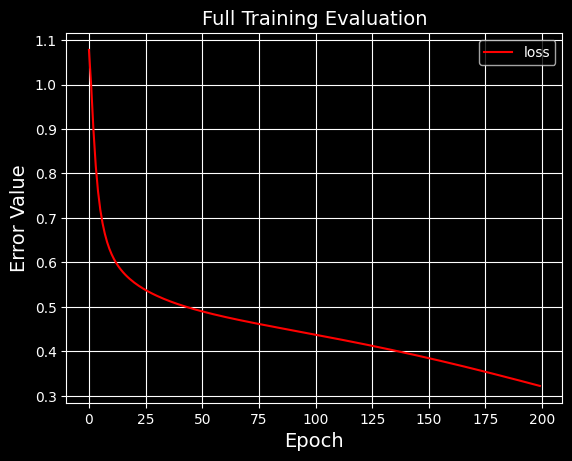

In [12]:
plt.plot(losses_2, label='loss', color='red')
plt.title('Full Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [13]:
model_2 = BalancedNeuralNetwork(5000,3)
state = torch.load("./torch_models/model_2.pth")
model_2.load_state_dict(state['state_dict'])

<All keys matched successfully>

In [14]:
y_test

tensor([1, 2, 2,  ..., 1, 2, 1])

In [15]:
predictions_2 = model_2.forward(X_test_vec)
predictions_2 = torch.softmax(predictions_2, dim=1)
predictions_2 = torch.argmax(predictions_2, dim=1)
predictions_2

tensor([1, 2, 2,  ..., 1, 1, 1])

In [16]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predictions_2)
accuracy

0.8454957221942627

In [17]:
from sklearn.metrics import recall_score

recall = recall_score(y_test, predictions_2, average='macro')
recall

0.8540639842913565

In [18]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions_2))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1550
           1       0.82      0.86      0.84      4451
           2       0.84      0.81      0.83      3934

    accuracy                           0.85      9935
   macro avg       0.86      0.85      0.86      9935
weighted avg       0.85      0.85      0.85      9935

